In [101]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [90]:
# use read_csv and info
data = pd.read_csv('cancer.csv',header=None)
data.info()
data = data.iloc[:-2, :]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       569 non-null    float64
 1   1       571 non-null    object 
 2   2       569 non-null    float64
 3   3       569 non-null    float64
 4   4       569 non-null    float64
 5   5       569 non-null    float64
 6   6       569 non-null    float64
 7   7       569 non-null    float64
 8   8       569 non-null    float64
 9   9       569 non-null    float64
 10  10      569 non-null    float64
 11  11      569 non-null    float64
 12  12      569 non-null    float64
 13  13      569 non-null    float64
 14  14      569 non-null    float64
 15  15      569 non-null    float64
 16  16      569 non-null    float64
 17  17      569 non-null    float64
 18  18      569 non-null    float64
 19  19      569 non-null    float64
 20  20      569 non-null    float64
 21  21      569 non-null    float64
 22  22

In [91]:
X = data.iloc[:, 2:].values
y = data.iloc[:, 1].values

# Convertir las etiquetas a valores numéricos
etiquetas = {"M": 1, "B": 0}
y = np.array(list(map(lambda x: etiquetas[x], y)))

# Normalización
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividiendo el dataset 70 y 30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

input_dim = X_train.shape[1]

In [124]:
class MLP:
    # Funciones de activación
    def sigmoide(self, x, derivada=False):
        if derivada:
             return self.sigmoide(x) * (1 - self.sigmoide(x))
        return 1 / (1 + np.exp(-x))

    def tanh(self, x, derivada=False):
        if derivada:
            return 1 - np.tanh(x) ** 2
        return np.tanh(x)

    def relu(self, x, derivada=False):
        if derivada:
            return np.where(x > 0, 1, 0)
        return np.maximum(0, x)

    # Funcion de perdida softmax
    def softmax(self, x, derivada=False):
        if derivada:
            s = self.softmax(x)
            return s * (1 - s)
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def __init__(self,num_caracteristicas,num_capas_ocultas,num_neuronas_x_capa_oculta,num_neuronas_salida,funcion_activacion):
        self.num_caracteristicas = num_caracteristicas # 30
        self.num_capas_ocultas = num_capas_ocultas # 2
        self.num_neuronas_x_capa_oculta = num_neuronas_x_capa_oculta # [3,2]
        self.num_neuronas_salida = num_neuronas_salida # 1
        self.funciones_activacion = {
            "sigmoide": self.sigmoide,
            "tanh": self.tanh,
            "relu": self.relu
        }
        self.funcion_activacion = self.funciones_activacion[funcion_activacion]
        self.alpha = None

        self.W_h = []
        for i in range(self.num_capas_ocultas):
            if i == 0:
                self.W_h.append(np.random.rand(self.num_caracteristicas,self.num_neuronas_x_capa_oculta[i]))
            else:
                self.W_h.append(np.random.rand(self.num_neuronas_x_capa_oculta[i-1],self.num_neuronas_x_capa_oculta[i]))
        self.W_o = np.random.rand(self.num_neuronas_x_capa_oculta[-1],self.num_neuronas_salida)
        #print(self.W_h[0].shape)
        #print(self.W_h[1].shape)
        #print(self.W_o[0].shape)

    def forward(self,X_i):
        salidas = [] # [(30,3),(3,2)]
        for i in range(self.num_capas_ocultas):
            if i == 0:
                salidas.append(self.relu(np.dot(X_i,self.W_h[i])))
            else:
                salidas.append(self.relu(np.dot(salidas[i-1],self.W_h[i])))
        output = self.funcion_activacion(np.dot(salidas[-1],self.W_o)) #(1,1)
        output = self.relu(output) # (1,1)
        return salidas, output

    def backward(self,X_i,y_i,salidas,output):
        delta_k = np.array(0.0).reshape(1,1)
        delta_w_list = []
        for k in range(output.shape[1]):
            delta_k += (output[0,k] - y_i[0,k]) * self.funcion_activacion(output[0,k],derivada=True) #(1,1)
            #s_k = (output[0,k] - y_i[0,k]) * self.funcion_activacion(output[0,k],derivada=True) # (1,1)
            #delta_k += np.dot(s_k,self.W_o.T)  # (1,1) * (1,2) = (1,2)
        for i in range(self.num_capas_ocultas): # 0,1
            dS_Net = self.funcion_activacion(salidas[-i-1],derivada=True) # print(dS_Net.shape): (1,2), (1,3)
            if i == 0: # print(dNet_w.shape): (1,3), (1,30)
                dNet_w = salidas[-i-2]
                #print(dNet_w.shape)
            else:
                dNet_w = X_i
                #print(dNet_w.shape)
            delta_w = np.dot(dNet_w.T,dS_Net * delta_k) # (3,1) * (1,2) = (3,2) , (30,1) * (1,3) = (30,3)
            delta_w_list.append(delta_w)
            #delta_k = np.dot(delta_k,self.W_h[-i-1].T) * dS_Net ?
        delta_w_list.reverse() # print(delta_w_list[0].shape): [(30,3), (3,2)]
        return delta_w_list,delta_k

    def update_weights(self,delta_w_list,delta_k,salidas): # delta_w = gradiente
        for i in range(self.num_capas_ocultas):
            if i == 0: # W_h[0] = (30,3)
                self.W_h[i] -= self.alpha * delta_w_list[i] # (30,1) * (1,3) = (30,3)
            else:
                self.W_h[i] -= self.alpha * delta_w_list[i] # (3,1) * (1,2) = (3,2)
            #delta_w = delta_w_list[-i-1] * self.funcion_activacion(salidas[-i-2], derivada=True)
            # (3,2) * (1,3)|(1,2) * (1,2) = (1,2)
        self.W_o -= self.alpha * np.dot(salidas[-1].T, delta_k) # (2,1) * (1,1) = (2,1) que esto es lo que espera en W_o (2,1)

    def train(self, X, y, alpha, epocas):
        losses = []  # Store losses for plotting
        self.alpha = alpha
        for epoca in range(epocas):
            for i in range(X.shape[0]):
                X_i = X[i:i+1,:] # (1,30)
                y_i = np.array(y[i]).reshape(1,1) # [1]
                salidas, output = self.forward(X_i)
                delta_w_list,delta_k = self.backward(X_i, y_i, salidas, output)
                self.update_weights(delta_w_list, delta_k, salidas)
            loss = self.calculate_loss(X_train, y_train)
            losses.append(loss)
            print(f"Epoch {epoca + 1}/{epocas}, Loss: {loss}")
        self.plot_loss_curve(losses)


    def plot_loss_curve(self, losses):
        plt.plot(losses)
        plt.title('Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()

    def calculate_loss(self, X, y):
        predictions = self.predict(X)
        mse_loss = np.mean((predictions - y) ** 2)
        return mse_loss

    def predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            X_i = X[i:i+1,:]
            salidas, output = self.forward(X_i)
            y_pred.append(output[0][0])
        return y_pred

Epoch 1/500, Loss: 0.2108123127614448
Epoch 2/500, Loss: 0.19610468316973342
Epoch 3/500, Loss: 0.17574464555821195
Epoch 4/500, Loss: 0.1724333533433339
Epoch 5/500, Loss: 0.1709878228136892
Epoch 6/500, Loss: 0.168029439695996
Epoch 7/500, Loss: 0.16514036307726432
Epoch 8/500, Loss: 0.1624231358670904
Epoch 9/500, Loss: 0.15989952380806313
Epoch 10/500, Loss: 0.15750102484167883
Epoch 11/500, Loss: 0.15521243584403188
Epoch 12/500, Loss: 0.15304318751460425
Epoch 13/500, Loss: 0.15099530029147792
Epoch 14/500, Loss: 0.1490174308109796
Epoch 15/500, Loss: 0.14710701647834554
Epoch 16/500, Loss: 0.14523647219072716
Epoch 17/500, Loss: 0.14344384154118722
Epoch 18/500, Loss: 0.1417162764300557
Epoch 19/500, Loss: 0.14006857412138257
Epoch 20/500, Loss: 0.1385021384474239
Epoch 21/500, Loss: 0.13694197757025653
Epoch 22/500, Loss: 0.13543376850076805
Epoch 23/500, Loss: 0.13397320635306859
Epoch 24/500, Loss: 0.132541804551049
Epoch 25/500, Loss: 0.1311572384110114
Epoch 26/500, Loss: 0

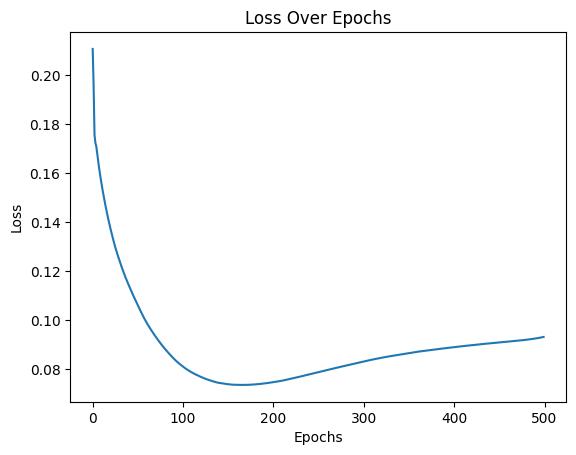

In [130]:
red_neuronal = MLP(num_caracteristicas=30, num_capas_ocultas=2,  num_neuronas_x_capa_oculta=[3,2], num_neuronas_salida=1, funcion_activacion="tanh")
red_neuronal.train(X_train, y_train, alpha=0.001, epocas=500)
y_pred = red_neuronal.predict(X_test)

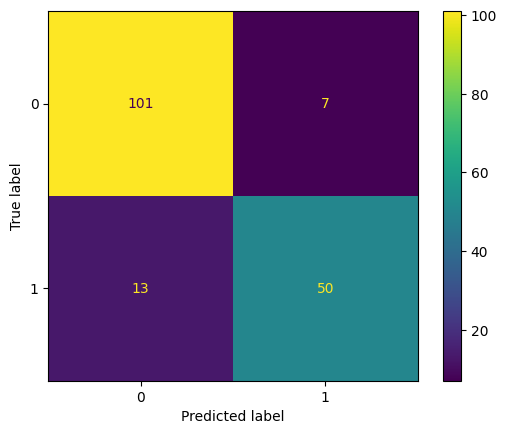

In [129]:

y_pred = red_neuronal.predict(X_test)

y_pred_binary = np.round(y_pred).flatten()
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot()
plt.show()